In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [3]:
display(train_data.head())
display(test_data.head())

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [4]:
display(train_data.isna().sum())
display(test_data.isna().sum())

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [5]:
display(train_data.shape)
display(test_data.shape)

(18524, 9)

(6175, 8)

In [6]:
display(train_data.describe())
display(test_data.describe())

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [7]:
print_object_columns = train_data.select_dtypes(include=['object']).columns
print_object_columns_element = {col: train_data[col].unique() for col in print_object_columns}
display(print_object_columns)
display(print_object_columns_element)

Index(['Stage_fear', 'Drained_after_socializing', 'Personality'], dtype='object')

{'Stage_fear': array(['No', 'Yes', nan], dtype=object),
 'Drained_after_socializing': array(['No', nan, 'Yes'], dtype=object),
 'Personality': array(['Extrovert', 'Introvert'], dtype=object)}

In [8]:
# Map values for 'Stage_fear' and 'Drained_after_socializing'
yes_no_map = {'Yes': 1, 'No': 0}
train_data['Stage_fear'] = train_data['Stage_fear'].map(yes_no_map)
train_data['Drained_after_socializing'] = train_data['Drained_after_socializing'].map(yes_no_map)
test_data['Stage_fear'] = test_data['Stage_fear'].map(yes_no_map)
test_data['Drained_after_socializing'] = test_data['Drained_after_socializing'].map(yes_no_map)

# Map values for 'Personality'
personality_map = {'Extrovert': 0, 'Introvert': 1}
train_data['Personality'] = train_data['Personality'].map(personality_map)

In [9]:
display(train_data.describe())
display(test_data.describe())

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
count,18524.000000,17334.000000,16631.000000,17344.000000,17058.000000,17375.000000,17470.000000,17260.000000,18524.000000
mean,9261.500000,3.137764,0.241838,5.265106,4.044319,0.233784,7.996737,4.982097,0.260473
std,5347.562529,3.003786,0.428209,2.753359,2.062580,0.423249,4.223484,2.879139,0.438905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000,0.000000
50%,9261.500000,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000,0.000000
75%,13892.250000,4.000000,0.000000,8.000000,6.000000,0.000000,12.000000,7.000000,1.000000
max,18523.000000,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000,1.000000


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5577.000000,5778.000000,5709.000000,5743.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,0.240452,5.287989,4.037835,0.227407,8.008412,5.028958
std,1782.713288,2.985658,0.427396,2.758052,2.045207,0.419194,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000
50%,21611.000000,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000
75%,23154.500000,4.000000,0.000000,8.000000,6.000000,0.000000,12.000000,7.000000
max,24698.000000,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000


In [10]:
print(train_data[['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                  'Friends_circle_size', 'Post_frequency']].skew())


Time_spent_Alone           1.133777
Social_event_attendance   -0.229238
Going_outside             -0.367221
Friends_circle_size       -0.051806
Post_frequency            -0.058706
dtype: float64


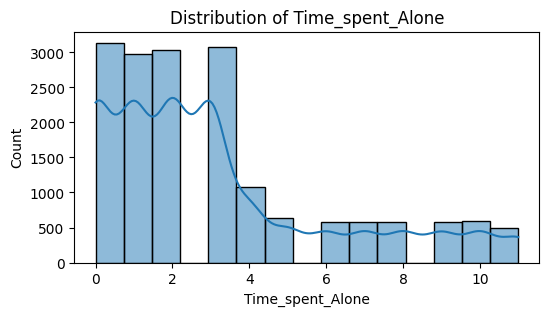

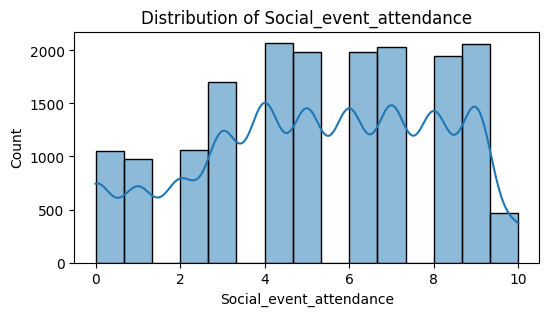

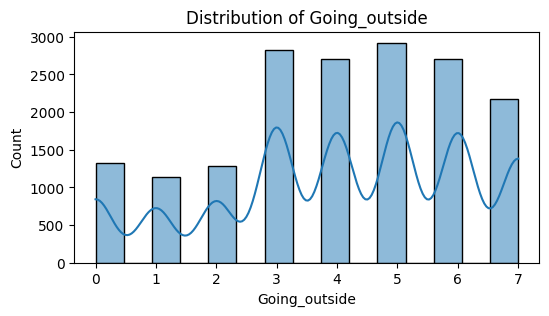

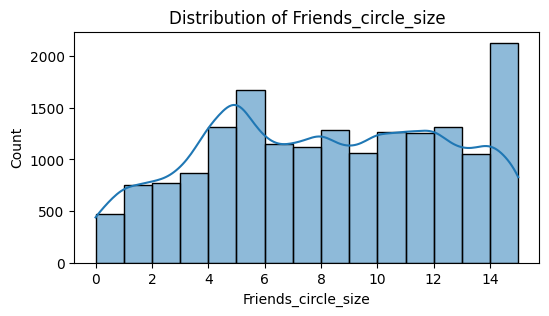

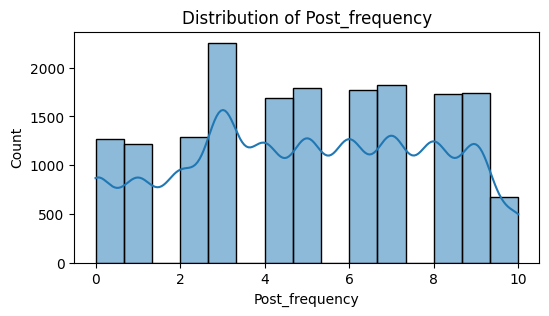

In [11]:
cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
        'Friends_circle_size', 'Post_frequency']

for col in cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(train_data[col], kde=True, bins=15)
    plt.title(f"Distribution of {col}")
    plt.show()


In [12]:
from sklearn.impute import KNNImputer

# Numeric columns
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
            'Friends_circle_size', 'Post_frequency']

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
train_data[num_cols] = knn_imputer.fit_transform(train_data[num_cols])
test_data[num_cols] = knn_imputer.transform(test_data[num_cols])

# Categorical columns
cat_cols = ['Stage_fear', 'Drained_after_socializing']
for col in cat_cols:
    mode_val = train_data[col].mode()[0]
    train_data[col] = train_data[col].fillna(mode_val)
    test_data[col] = test_data[col].fillna(mode_val)

In [13]:
display(train_data)
display(test_data)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0.0,6.0,4.0,0.0,15.0,5.0,0
1,1,1.0,0.0,7.0,3.0,0.0,10.0,8.0,0
2,2,6.0,1.0,1.0,0.0,0.0,3.0,0.0,1
3,3,3.0,0.0,7.0,3.0,0.0,11.0,5.0,0
4,4,1.0,0.0,4.0,4.0,0.0,13.0,6.4,0
...,...,...,...,...,...,...,...,...,...
18519,18519,3.0,0.0,7.0,3.0,0.0,9.0,7.0,0
18520,18520,1.0,0.0,6.0,7.0,0.0,6.0,5.0,0
18521,18521,7.0,1.0,1.0,1.0,1.0,1.0,0.8,1
18522,18522,9.4,1.0,1.0,0.0,1.0,5.0,2.0,1


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,0.0,7.0,4.0,0.0,6.0,6.0
1,18525,7.4,1.0,0.0,0.0,1.0,5.0,1.0
2,18526,3.0,0.0,5.0,6.0,0.0,15.0,9.0
3,18527,3.0,0.0,4.0,4.0,0.0,5.0,6.0
4,18528,9.0,1.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
6170,24694,3.0,0.0,5.0,5.0,0.0,9.0,6.0
6171,24695,8.0,1.0,2.0,1.0,1.0,0.0,0.0
6172,24696,2.0,0.0,4.0,3.0,0.0,9.0,7.0
6173,24697,3.0,0.0,4.0,4.0,0.0,11.0,9.0


In [14]:
display(train_data.isna().sum())
display(test_data.isna().sum())

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64

In [15]:
new_train_data = train_data.drop(columns=['id','Personality'],axis=1)
new_test_data = test_data.drop('id',axis=1)

In [16]:
display(new_train_data)
display(new_test_data)

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0.0,0.0,6.0,4.0,0.0,15.0,5.0
1,1.0,0.0,7.0,3.0,0.0,10.0,8.0
2,6.0,1.0,1.0,0.0,0.0,3.0,0.0
3,3.0,0.0,7.0,3.0,0.0,11.0,5.0
4,1.0,0.0,4.0,4.0,0.0,13.0,6.4
...,...,...,...,...,...,...,...
18519,3.0,0.0,7.0,3.0,0.0,9.0,7.0
18520,1.0,0.0,6.0,7.0,0.0,6.0,5.0
18521,7.0,1.0,1.0,1.0,1.0,1.0,0.8
18522,9.4,1.0,1.0,0.0,1.0,5.0,2.0


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,3.0,0.0,7.0,4.0,0.0,6.0,6.0
1,7.4,1.0,0.0,0.0,1.0,5.0,1.0
2,3.0,0.0,5.0,6.0,0.0,15.0,9.0
3,3.0,0.0,4.0,4.0,0.0,5.0,6.0
4,9.0,1.0,1.0,2.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
6170,3.0,0.0,5.0,5.0,0.0,9.0,6.0
6171,8.0,1.0,2.0,1.0,1.0,0.0,0.0
6172,2.0,0.0,4.0,3.0,0.0,9.0,7.0
6173,3.0,0.0,4.0,4.0,0.0,11.0,9.0


<Axes: ylabel='count'>

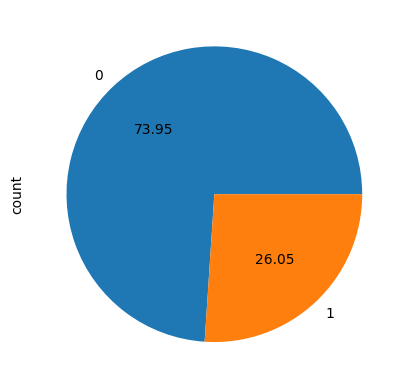

In [17]:
train_data.Personality.value_counts().plot.pie(autopct='%.2f')

In [18]:
x = new_train_data
y = train_data.Personality
X_train,X_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [19]:
samp = SMOTE()
X_resampled, y_resampled  = samp.fit_resample(X_train,y_train)

Personality
0    10280
1    10280
Name: count, dtype: int64

<Axes: ylabel='count'>

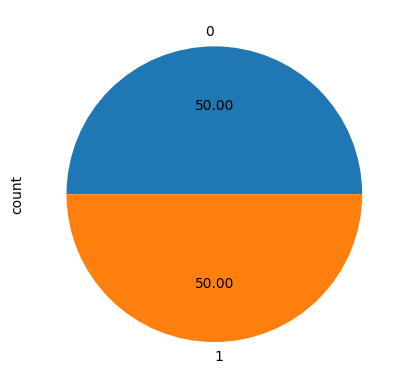

In [20]:
display(y_resampled.value_counts())
y_resampled.value_counts().plot.pie(autopct='%.2f')

In [21]:
tree_model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 150, 200, 250],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        }
    },
    'lightgbm': {
        'model': LGBMClassifier(verbose=-1),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [31, 50, 100],
            'boosting_type': ['gbdt', 'dart']
        }
    },
    'adaboost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 1.0],
        }
    },
    'bagging': {
        'model': BaggingClassifier(),
        'params': {
            'n_estimators': [10, 50, 100],
            'max_samples': [0.5, 0.7, 1.0]
        }
    }
}

In [22]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = []
for model_name, model_details in tree_model_params.items():
    param_space_size = len(ParameterGrid(model_details['params']))  # Get total possible combinations
    n_iter_adjusted = min(10, param_space_size)  # Adjust `n_iter` dynamically

    clf = RandomizedSearchCV(
        model_details['model'],
        model_details['params'],
        n_iter=n_iter_adjusted,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_resampled, y_resampled)
    
    results.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='best_score', ascending=False)

In [33]:
results_df

,model,best_score,best_params
3,lightgbm,0.975195,"{'num_leaves': 100, 'n_estimators': 150, 'lear..."
2,gradient_boosting,0.973735,"{'n_estimators': 150, 'min_samples_split': 10,..."
5,bagging,0.973103,"{'n_estimators': 100, 'max_samples': 0.7}"
1,random_forest,0.971401,"{'n_estimators': 250, 'min_samples_split': 5, ..."
4,adaboost,0.960263,"{'n_estimators': 150, 'learning_rate': 1.0}"
0,decision_tree,0.953940,"{'splitter': 'random', 'criterion': 'entropy'}"


In [34]:
print(results_df.loc[results_df['model'] == 'lightgbm', 'best_params'].values[0])

{'num_leaves': 100, 'n_estimators': 150, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}


In [35]:
model_lgm = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=150, num_leaves=100, objective='binary')
model_lgm.fit(X_train,y_train)

LGBMClassifier(n_estimators=150, num_leaves=100, objective='binary')

In [36]:
y_pred = model_lgm.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3419
           1       0.94      0.91      0.93      1212

    accuracy                           0.96      4631
   macro avg       0.96      0.95      0.95      4631
weighted avg       0.96      0.96      0.96      4631



In [37]:
from sklearn.metrics import roc_curve

# True labels on validation set
y_true = y_test  # or whatever your validation target is
y_proba = model_lgm.predict_proba(X_test)[:, 1]

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold = {optimal_threshold:.4f}")


Optimal Threshold = 0.1997


In [38]:
# Get predicted probabilities for class 1 (Introvert)
y_pred_proba = model_lgm.predict_proba(new_test_data)[:, 1]

# Use optimal threshold to classify
y_pred = (y_pred_proba >= 0.1997).astype(int)

In [39]:
personality_map = {0: 'Extrovert', 1: 'Introvert'}
y_label = pd.Series(y_pred).map(personality_map)

In [40]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'Personality': y_label
})

submission.to_csv('submission.csv', index=False)

In [41]:
print(y_label.value_counts())

Extrovert    4543
Introvert    1632
Name: count, dtype: int64


In [42]:
from sklearn.metrics import classification_report

y_val_pred = (model_lgm.predict_proba(X_test)[:, 1] >= 0.1997).astype(int)
print(classification_report(y_test, y_val_pred, target_names=['Extrovert', 'Introvert']))


              precision    recall  f1-score   support

   Extrovert       0.98      0.97      0.97      3419
   Introvert       0.92      0.93      0.93      1212

    accuracy                           0.96      4631
   macro avg       0.95      0.95      0.95      4631
weighted avg       0.96      0.96      0.96      4631

